In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [55]:
df = pd.read_csv('disaster_tweets.csv')

In [56]:
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [58]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,7613.0,5441.934848,3137.11609,1.0,2734.0,5408.0,8146.0,10873.0
target,7613.0,0.429660,0.49506,0.0,0.0,0.0,1.0,1.0


In [59]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [60]:
df['text'].to_list()

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area...",
 'Three people died from the heat wave so far',
 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA 

##DATA CLEANING

In [61]:
# FUNZIONE CHE MI AGGREGA TUTTI COMANDI DI REGEX PER IL DATA CLEANING
import re

def clean_special_patterns(text):
    """Remove special patterns - email, url, date etc."""
    html_regex = re.compile(r"<.*?>")
    email_regex = re.compile(r"[\w.-]+@[\w.-]+")
    url_regex = re.compile(r"(http|www)[^\s]+")
    date_regex = re.compile(r"[\d]{2,4}[ -/:]*[\d]{2,4}([ -/:]*[\d]{2,4})?") # a way to match date
    new_line = re.compile(r"/(\r\n)+|\r+|\n+|\t+/")
    number = re.compile(r"[\d+]")
    under = re.compile(r"[^a-zA-Z0-9:$-,%.?!]+")
    simbols = re.compile(r"[^\w\s/'/`]")
    spaces = re.compile(r"\s{2,}")
    remove_singlelett= re.compile(r"(^| ).( |$)")

    ## remove
    text = text.lower()
    text = number.sub(" ", text)
    text = html_regex.sub(" ", text)
    text = url_regex.sub(" ", text)
    text = email_regex.sub(" ", text)
    text = date_regex.sub(" ", text)
    text = new_line.sub(" ", text)
    text = under.sub(" ", text)
    text = simbols.sub(" ", text)
    text = spaces.sub(" ", text)
    text = text.replace("`", "'")
    text = remove_singlelett.sub("",text)
    return text

In [62]:
# APPLICO LA FUNZIONE SU TUTTO IL TEXT
df["text"] = df["text"].apply(clean_special_patterns)
df

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holdingbridge collapse into n...,1
7609,10870,NaN,NaN,aria ahrary thetawniest the out of control wi...,1
7610,10871,NaN,NaN,utc kmof volcano hawaii ebj,1
7611,10872,NaN,NaN,police investigating after anbike collided wit...,1


In [63]:
df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

##STOP WORDS + LEMMATIZATION

In [64]:
## Spacy Custom Pipeline
import numpy as np
import multiprocessing as mp

import string
import spacy 
from sklearn.base import TransformerMixin, BaseEstimator


nlp = spacy.load("en_core_web_sm")

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 nlp = nlp,
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Punctuation removal
            2. Stop words removal
            3. Lemmatization

        nlp  - spacy model
        n_jobs - parallel jobs to run
        """
        self.nlp = nlp
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _remove_punct(self, doc):
        return (t for t in doc if t.text not in string.punctuation)

    def _remove_stop_words(self, doc):
        return (t for t in doc if not t.is_stop)

    def _lemmatize(self, doc):
        return ' '.join(t.lemma_ for t in doc)

    def _preprocess_text(self, text):
        doc = self.nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

In [65]:
#takes 2 min of processing
text_preprocess = TextPreprocessor(n_jobs=-1)._preprocess_text
#df["text"][0:10].apply(text_preprocess)
df["text"] = df["text"].apply(text_preprocess)
df

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake allah forgive,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident ask shelter place notify officer evac...,1
3,6,NaN,NaN,people receive wildfire evacuation order cal...,1
4,7,NaN,NaN,get send photo ruby alaska smoke wildfire pour...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,giant crane holdingbridge collapse nearby home,1
7609,10870,NaN,NaN,aria ahrary thetawniest control wild fire ca...,1
7610,10871,NaN,NaN,utc kmof volcano hawaii ebj,1
7611,10872,NaN,NaN,police investigate anbike collide withcar litt...,1


##EDA

In [66]:
cleaned = ' '.join(df['text'].to_list())

(-0.5, 799.5, 399.5, -0.5)

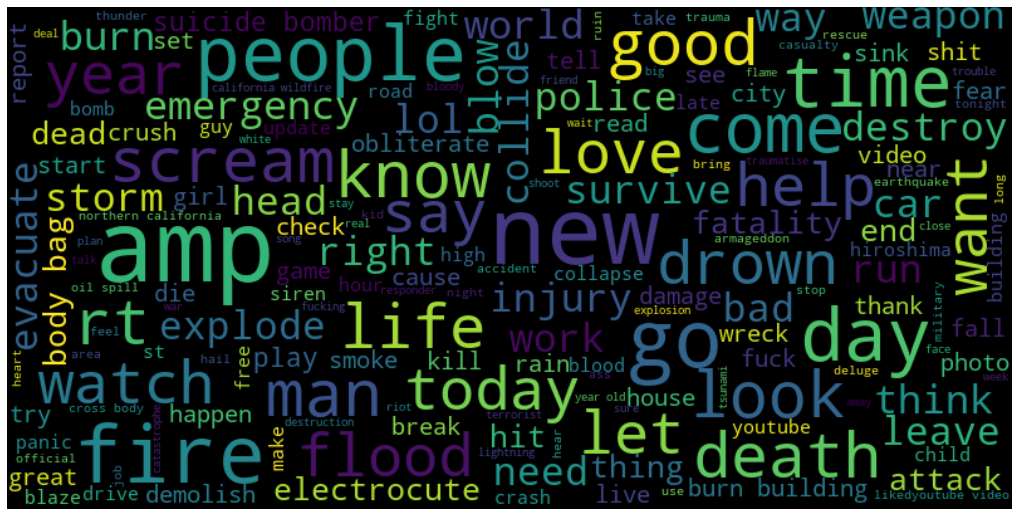

In [67]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 667)

wordcloud.generate(cleaned)

plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

##BAG OF WORDS

###DICHIARO LA FEATURE E LA TARGET

In [68]:
X = df['text'] # FEATURES
y = df['target'] # TARGET

In [69]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)

X_ = vectorizer.fit_transform(X).toarray()
X_

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

##TF-IDF

In [70]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfconverter = TfidfTransformer()
X_ = tfidfconverter.fit_transform(X_).toarray()
X_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.41060152, ..., 0.        , 0.        ,
        0.        ]])

##SPLIT

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

###DICHIARO LE LABELS

In [72]:
labels = ['NO DISASTER', 'DISASTER']

###RANDOMFOREST

In [73]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=1000, random_state=667,max_depth=5)
classifier.fit(X_train, y_train) 

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=667)

In [74]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_pred, y_test)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.625


Text(69.0, 0.5, 'Actual')

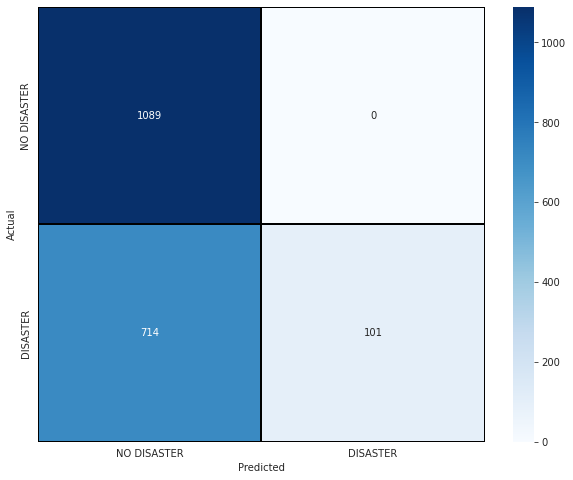

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [76]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

 NO DISASTER       0.60      1.00      0.75      1089
    DISASTER       1.00      0.12      0.22       815

    accuracy                           0.62      1904
   macro avg       0.80      0.56      0.49      1904
weighted avg       0.77      0.62      0.53      1904



In [77]:
!pip install plot-metric --quiet

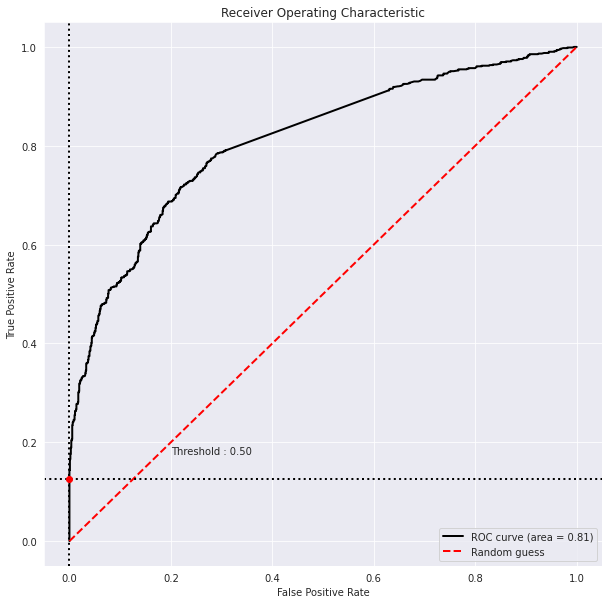

In [78]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

##MULTINOMIAL NB

In [79]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train) 

MultinomialNB()

In [80]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.7935924369747899


Text(69.0, 0.5, 'Actual')

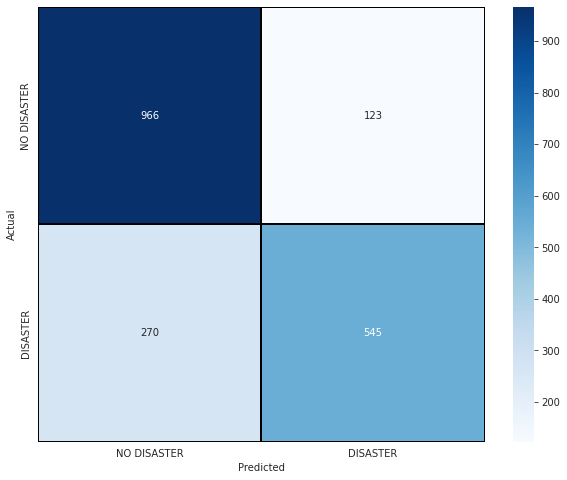

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [82]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

 NO DISASTER       0.78      0.89      0.83      1089
    DISASTER       0.82      0.67      0.73       815

    accuracy                           0.79      1904
   macro avg       0.80      0.78      0.78      1904
weighted avg       0.80      0.79      0.79      1904



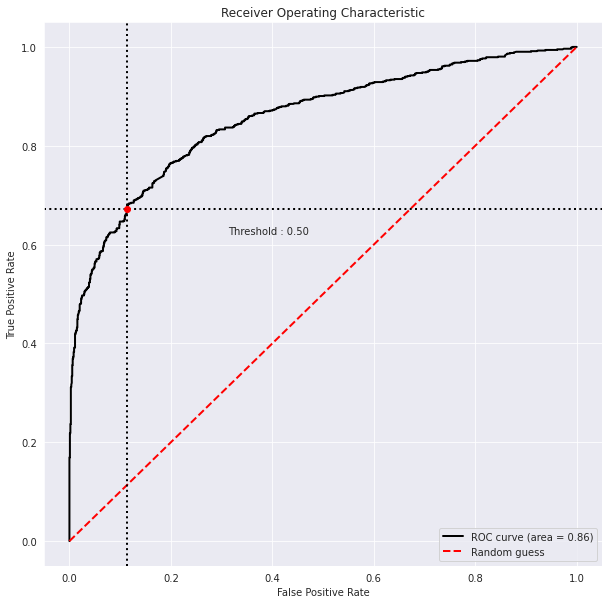

In [83]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

##SGD CLASSIFIER

In [84]:
# accuracy score on the test data
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=667, max_iter=5, tol=None)
classifier.fit(X_train, y_train) 

y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_pred, y_test)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.7379201680672269


Text(69.0, 0.5, 'Actual')

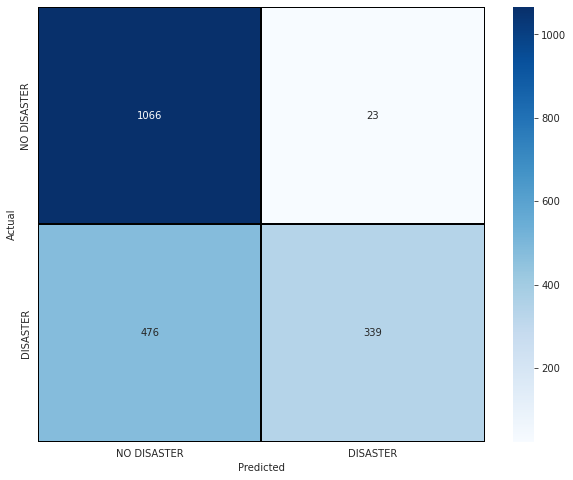

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [86]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

 NO DISASTER       0.69      0.98      0.81      1089
    DISASTER       0.94      0.42      0.58       815

    accuracy                           0.74      1904
   macro avg       0.81      0.70      0.69      1904
weighted avg       0.80      0.74      0.71      1904



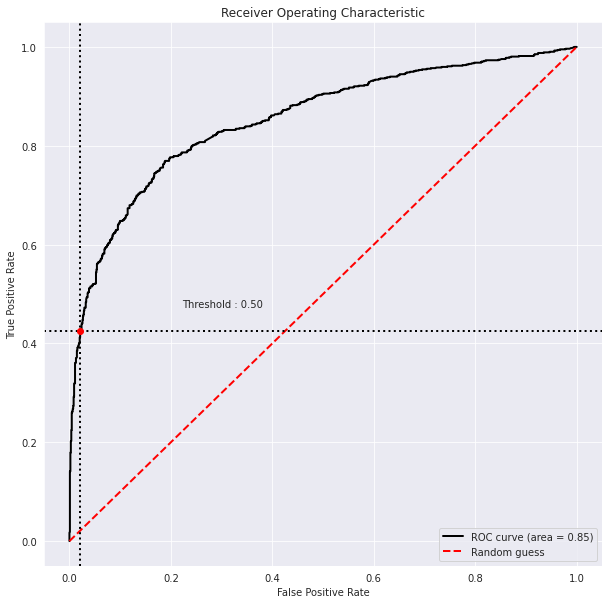

In [87]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

##PIPELINE

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

In [89]:
from sklearn.pipeline import Pipeline

text_preprocess = TextPreprocessor(n_jobs=-1)
bow = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
tfidf = TfidfTransformer()
classifier = MultinomialNB()

pipe = Pipeline([
                ('lemma_stop_rem',text_preprocess),
                ('bow',bow),
                ('tfidf',tfidf),
                ('clf',classifier),
                ])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)
test_data_accuracy = accuracy_score(predicted, y_test)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.7899159663865546


In [90]:
test = pd.Series({'text':'the beer is finished'})

In [91]:
prediction = pipe.predict(test)
print(prediction[0])

if (prediction[0] == 0):
  print('disaster')
else:
  print('no disaster')

0
disaster


In [92]:
import joblib

joblib.dump(pipe,'pipeline_classifier_SpaCy.pkl')

['pipeline_classifier_SpaCy.pkl']